<a href="https://colab.research.google.com/github/hughjonesd/course-nlp/blob/master/anton_svd_on_scmij.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic Modelling with NMF and SVD

---

Test of the Python functions and methods on the previously used data set of all journal articles from Supply Chain Management: An International Journal (1994-2019). 

I'm not able to do a train/test split as my data is not labelled with topics. But I'll have a go at loading and pre-processing data as well as generating some topics on a subset of papers.

The goal of the initial analysis was to conduct an unsupervised literature review of the whole journal corpus for it's 25th anniversary. Topics are identified and described. We also classified topics into 'hot', 'cold' and 'stable' to identify their trajectory over time. 

This analysis attempts to replicte some of the topic modelling previously performed with LDA in R. Previously identified topic labels could be used as a validation check of the new solution.


## Environment setup

In [1]:
# load the necessary libraries
import pandas as pd
import numpy as np
import nltk
from scipy import linalg
from sklearn import decomposition
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
np.set_printoptions(suppress=True)

## Data load

First, I need to load my csv file - I upload it to the 'content' directory on the server from my machine.


In [3]:
full_texts = pd.read_csv("full_pdf_texts.csv", encoding="Latin-1") 

FileNotFoundError: ignored

Let's have a look at the loaded data.

In [ ]:
full_texts.describe

<bound method NDFrame.describe of             filename                                               text
0      article_1.pdf  Trust power and supply chain integration in We...
1     article_10.pdf  Blockchain technology implications for operati...
2    article_100.pdf  Introduction Research paper Partnership sourci...
3    article_103.pdf  Trade in the st century will be driven by Rese...
4    article_106.pdf   Introduction Research paper Achieving high In...
..               ...                                                ...
893  article_708.pdf  Facing disruptive technologies aligning purcha...
894  article_860.pdf  Barriers to implementing reverse logistics in ...
895  article_886.pdf  Towards an integrated conceptual model of supp...
896  article_902.pdf  Analysing supply chain integration through a s...
897  article_905.pdf  Supply chain readiness response and recovery f...

[898 rows x 2 columns]>

In [ ]:
full_texts.head()

,filename,text
0,article_1.pdf,Trust power and supply chain integration in We...
1,article_10.pdf,Blockchain technology implications for operati...
2,article_100.pdf,Introduction Research paper Partnership sourci...
3,article_103.pdf,Trade in the st century will be driven by Rese...
4,article_106.pdf,Introduction Research paper Achieving high In...


In [ ]:
full_texts.iloc[2]['text']

"Introduction, Research paper, Partnership sourcing is often perceived as the, Pre-construction, best approach to achieving supply chain, project partnering:, improvement through the development of, more effective customer-supplier, from adversarial to, relationships. A large body of literature now, collaborative, exists which presents various approaches to, the general idea from a wide range of, relationships, industrial and academic perspectives (Moore, et al., 1992; Carr and Truesdale, 1992;, Paul Humphreys, Macbeth and Ferguson, 1994), including, Jason Matthews and, dyadic collaborative relationships, the, network concept in relationship marketing, Monan Kumaraswamy, and the development of strategic alliances, (Harland, 1996; Harland et al., 1999)., The authors, Nevertheless, as a number of articles and, Paul Humphreys is a Reader at the School of, reports (Lamming, 1994; Burnes and New,, Management, University of Ulster, Newtownabbey, UK., Jason Matthews is a Research Assistant in

It has only two columns - a unique ID and the text of the whole article. An exemplary text is shown above. 

Texts were preprocessed before so the 'cover page' and most of the list of references pages were removed. 

## Data processing

First, let's pre-process the data mostly following the fast-ai notebook but also adding some additional steps.

In [ ]:
# remove digits from the text
full_texts['text'] = full_texts['text'].str.replace('\d+', '') # for digits
full_texts['text'] = full_texts['text'].str.replace('[^\w\s]', '') # for punctuation 
# this is too drastic - I need to remove standalone digits, but should leave digits which are part of terms, such as '3pl/4pl', or 'industry 4.0'

Add corpus-relevant stop words to the original sklearn list.

In [ ]:
# create a list with additional stop words
my_additional_stop_words = ["0", "1", "2", "3", "4", "5", "6", "7",
                  "0 0 0", "1 1 1", "0.0", "0.0 0.0", "0.0 0.0 0.0", "1.00", "1.00 1.00", "0.000 0.000 0.000", "0.000 0.000", "0.000",
                  "0.061", "1.33", "01 54 31", "121", "0.082", "35", "34", "0.68",
                  "e", "cc", "p", "r", "cl", "cf", "et", "al", "",
                  "w2", "hf",  "j5", "6x", "7h", "i4", "v4", "n1", "0y", "b1", "w5", "x1", "x2", "x3", "c5", "w.y", "6t", "r4", "m1", "t2", "t1", "t3",
                  "7y", "7yv",
                  "e.g", "e.g.", "article", "articles", "research", "paper", "papers", "study", "studies", "table", "journal", "practical", "implications",
                  "introduction", "discussion", "methodology", "results", "conclusions", "conclusion", "abstract", "volume", "vol", "volumes"]

# import the text object to extract the list of sklearn stop words
from sklearn.feature_extraction import text 
stop_words = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words)

Setup and run the vectorizer

In [ ]:
vectorizer = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,3), min_df=0.01)

In [ ]:
vectors = vectorizer.fit_transform(full_texts['text']).todense()
vectors.shape

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['00', '000', '01', '061', '082', '31', '33', '54', '68'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


(898, 41565)

In [ ]:
vocab = np.array(vectorizer.get_feature_names())
vocab.shape

(41565,)

View some of the terms.

In [ ]:
vocab[5500:5530]

array(['chapters', 'charac', 'character', 'characterisation',
       'characterise', 'characterised', 'characterised high',
       'characterises', 'characterising', 'characteristic',
       'characteristics', 'characteristics associated',
       'characteristics business', 'characteristics demand',
       'characteristics different', 'characteristics firm',
       'characteristics industry', 'characteristics market',
       'characteristics mitigation', 'characteristics performance',
       'characteristics product', 'characteristics products',
       'characteristics relationship', 'characteristics respondents',
       'characteristics supplier', 'characteristics supply',
       'characteristics supply chain', 'characteristics used',
       'characterization', 'characterize'], dtype='<U39')

In [ ]:
from nltk import stem
porter = stem.porter.PorterStemmer()

In [ ]:
[porter.stem(word) for word in vocab[5500:5530]]

['chapter',
 'charac',
 'charact',
 'characteris',
 'characteris',
 'characteris',
 'characterised high',
 'characteris',
 'characteris',
 'characterist',
 'characterist',
 'characteristics associ',
 'characteristics busi',
 'characteristics demand',
 'characteristics differ',
 'characteristics firm',
 'characteristics industri',
 'characteristics market',
 'characteristics mitig',
 'characteristics perform',
 'characteristics product',
 'characteristics product',
 'characteristics relationship',
 'characteristics respond',
 'characteristics suppli',
 'characteristics suppli',
 'characteristics supply chain',
 'characteristics us',
 'character',
 'character']

### Set up the Lemma Tokenizer.

In [ ]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

In [ ]:
# download the necessary nltk resources
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
vectorizer_lemma = TfidfVectorizer(stop_words=stop_words, tokenizer=LemmaTokenizer(), ngram_range=(1,3), min_df=0.01)

In [ ]:
vectors_lemma = vectorizer_lemma.fit_transform(full_texts['text']).todense()
vectors_lemma.shape

(898, 45632)

In [ ]:
vocab_lemma = np.array(vectorizer_lemma.get_feature_names())
vocab_lemma.shape

(45632,)

In [ ]:
vocab_lemma[5812:5842]

array(['chapter', 'charac', 'character', 'characterisation',
       'characterise', 'characterised', 'characterised high',
       'characterises', 'characterising', 'characteristic',
       'characteristic affect', 'characteristic associated',
       'characteristic business', 'characteristic company',
       'characteristic customer', 'characteristic demand',
       'characteristic different', 'characteristic firm',
       'characteristic important', 'characteristic industry',
       'characteristic market', 'characteristic mitigation',
       'characteristic number', 'characteristic organization',
       'characteristic performance', 'characteristic product',
       'characteristic relationship', 'characteristic respondent',
       'characteristic sample', 'characteristic supplier'], dtype='<U47')

## SVD

Fit SVD.

In [ ]:
%time U, s, Vh = linalg.svd(vectors, full_matrices=False)

CPU times: user 44.6 s, sys: 3.55 s, total: 48.2 s
Wall time: 25 s


In [ ]:
print(U.shape, s.shape, Vh.shape)

(898, 898) (898,) (898, 66058)


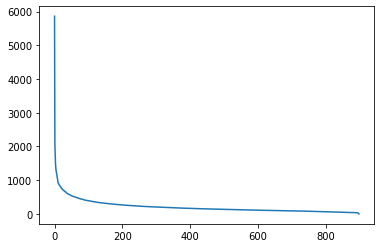

In [ ]:
plt.plot(s);

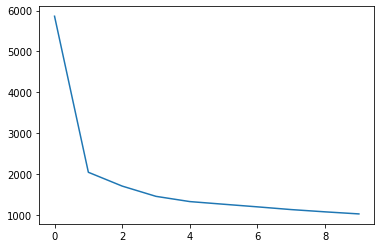

In [ ]:
plt.plot(s[:10])

In [ ]:
num_top_words=10

def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

In [ ]:
show_topics(Vh[:10])

['hectic paperclips typesetting divested normanton tupe sandy truths',
 'supply chain product demand information chains order planning',
 'supply fb01 chain et al resilience chains risk',
 'al et 2d31 performance integration environmental green logistics',
 'performance supplier integration chain supply customer relationship suppliers',
 'supplier suppliers supply risk social power buyer risks',
 'logistics performance fb01 service integration customer information cost',
 'performance management sustainability environmental practices social risk logistics',
 'practices environmental sustainability product green social fb01 firms',
 'product risk 2d31 quality practices green food products']

## NMF

In [ ]:
m,n=vectors.shape
d=80  # number of topics - do 80 as in my previous analysis

In [ ]:
clf = decomposition.NMF(n_components=d, random_state=1)

W1 = clf.fit_transform(vectors)
H1 = clf.components_

In [ ]:
# define the function to return top 10 terms for each topic
num_top_words=10

def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [', '.join(t) for t in topic_words]

In [ ]:
show_topics(H1)

['supply, chain, supply chain, management, chains, chain management, supply chains, supply chain management, strategy, information',
 'fb, fb rms, rms, fb rm, rm, signi, signi fb, speci fb, speci, fb ed',
 'supplier, suppliers, buyer, supplier development, relationship, development, buying firm, management, relationships, buying',
 'green, environmental, green purchasing, green supply, management, supply, environmental management, greening, environmental performance, energy',
 'sustainability, sscm, sustainable, social, environmental, social sustainability, sustainable supply, practices, supply, sustainability performance',
 'auctions, online reverse, reverse auctions, auction, online, reverse, online reverse auctions, emiliani, stec, reverse auction',
 'construction, contractors, client, construction supply, construction industry, contractor, project, subcontractors, construction supply chain, partnering',
 'logistics, transportation, management, transport, freight, distribution, firm

## NMF on lemmatized corpus


In [ ]:
m,n=vectors.shape
d=80  # number of topics - do 80 as in my previous analysis

In [ ]:
clf = decomposition.NMF(n_components=d, random_state=1)

W1_lemma = clf.fit_transform(vectors_lemma)
H1_lemma = clf.components_

In [ ]:
show_topics(H1_lemma)

IndexError: ignored